**Advanced Modeling**
- 

Building upon the insights gained from the baseline modeling phase, this notebook focuses on advancing the predictive capabilities of our NFL fantasy points model by leveraging gradient boosting. Gradient boosting models, known for their robustness and ability to capture non-linear relationships, should be well-suited for handling the complexities and variability inherent in player performance data.

**Objectives**

- Develop advanced models for predicting fantasy points across different positions (e.g., QB, RB, WR, TE)

- Implement Gradient Boosting to enhance predictive performance

- Evaluate the impact of ensemble methods in capturing the positional nuances identified in the baseline models

**Key Advancements Over Baseline Models**

- Non-linear Modeling: Unlike linear regression, Gradient Boosting can naturally handle non-linear patterns, which are prevalent in sports performance metrics

- Feature Interactions: Ensemble methods inherently capture complex interactions between cumulative metrics, rolling averages, and other features

- Position-Specific Insights: Utilizing Gradient Boosting for each position should provide deeper insights into the key predictors for each position

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Gradient Boosting**
- 

Gradient Boosting is a machine learning technique that builds predictive models in an iterative method by combining multiple weak learners to form a strong learner. "Boosting" refers to the sequential process of improving the model by minimizing the errors of previous models. Gradient boosting algorithms will be used to model player performance as they excel at working with small to medium datasets by fine-tuning errors iteratively. They also typically outperform linear regression models (such as the baseline model) because gradient boosting captures non-linear relationships between features and the target variable, whereas linear regression assumes a strictly linear relationship. Player statistics and fantasy points have complex, sometimes non-linear interactions, potentially making gradient boosting a better fit. Gradient boosting can also model complex relationships between features and outcomes effectively.


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

Importing Libraries/Packages

In [32]:
dfAll = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/ModelingDataframes/dfAll.csv")
qbsM = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/ModelingDataframes/qbsM.csv")
rbsM = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/ModelingDataframes/rbsM.csv")
wrsM = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/ModelingDataframes/wrsM.csv")
tesM = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/ModelingDataframes/tesM.csv")

Importing DataFrames

In [33]:
qbsM.head(5)

,Unnamed: 0,PLAYER NAME,PLAYER TEAM,PLAYER POSITION,STATUS,TOTAL,Opponent,Location,rank,DATE,...,season_rushing_td,season_total_avg,season_passing_yds_avg,season_passing_td_avg,season_receiving_rec_avg,season_receiving_yds_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_fantasy_points_avg
0,335,AJ McCarron,Cin,QB,W 31-14,0.80,Cle,Home,34.0,01-09-24,...,0.0,0.80,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.80
1,300,AJ McCarron,Cin,QB,W 34-14,-0.04,Ind,Home,38.0,12-12-23,...,0.0,0.38,9.5,0.0,0.0,0.0,0.0,0.0,0.0,0.38
2,75,Aaron Rodgers,NYJ,QB,W 22-16,0.00,Buf,Home,36.0,09-12-23,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,468,Aidan O'Connell,LV,QB,L 20-23,20.26,Ind,Away,9.0,01-02-24,...,0.0,20.26,299.0,2.0,0.0,0.0,0.0,2.0,3.0,20.26
4,312,Aidan O'Connell,LV,QB,W 27-14,17.86,Den,Home,11.0,01-09-24,...,0.0,19.06,271.5,2.0,0.0,0.0,0.0,3.0,2.0,19.06


- Ensuring DataFrames have been transfered correctly

**Model Pipeline**
- 

In [34]:
estimators = [
    ('imputer', SimpleImputer()),  
    #handles missing values
    ('model', GradientBoostingRegressor()) 
    #model being used
]

pipe = Pipeline(estimators)

paramGrid = {'model__learning_rate': [0.01, 0.1, 0.2],
             'model__n_estimators': [100, 200, 500],
             'model__max_depth': [3, 5, 7],
             'model__min_samples_split': [2, 5, 10], 
             'model__min_samples_leaf': [1, 3, 5],    
             'model__subsample': [0.8, 1.0],          
             'imputer__strategy': ['mean', 'median', 'most_frequent', 'constant']
}

**Pipeline Architecture**
- 

A pipeline is used to combine multiple processing steps into a single workflow, ensuring consistency and reproducibility while simplifying hyperparameter tuning.

**Hyperparameters**
- Learning Rate:
    - Controls the step size at each iteration while minimizing the loss
    - Smaller values allow for a more fine-grained optimization, which reduces the risk of overfitting
    - Suitable for the dataset, since predictions involve subtle relationships between variables
- Number of Estimators:
    - Determines the number of boosting rounds (trees) to build
    - A higher number of trees generally improves accuracy but increases the risk of overfitting
- Maximum Depth:
    - Controls the depth of each tree, limiting its complexity
    - Shallow trees help prevent overfitting but may miss complex patterns in player performance
    - Deeper trees can capture intricate interactions, which is important in the context of NFL data where player performance depends on various different factors
- Minimum Samples Split:
    - Specifies the minimum number of samples required to split an internal node
    - Larger values prevent the model from learning overly specific splits, which reduces overfitting
    - Smaller values allow the model to capture more specific patterns in the data, which might be useful for rare interactions in player performance
- Minimum Samples Leaf:
    - Specifies the minimum number of samples required to be in a leaf node
    - Larger values result in smoother predictions and reduce overfitting by ensuring splits aren't based on small, possibly noisy samples
    - Smaller values allow the model to capture more granular patterns, which can be beneficial for capturing outlier performances
- Subsample:
    - Specifies the fraction of the training data used for each tree
    - Helps in reducing overfitting by introducing randomness
    - Values like 0.8 and 1.0 ensure trees are trained on sufficient but not identical data
- Imputer Strategy
    - Specifies the strategy used for imputing values
    - Options include mean, median, most frequent, and constant

**Estimators**
- Imputer:
    - Handles missing values in the dataset by replacing them with specified strategies (mean, median, most frequent, and constant)
- GradientBoostingRegressor:
    - Tradtional gradient boosting

**Workflow**
- 
1. The imputer processes the data to handle missing values based on the specified strategy.
2. The preprocessed data is passed to the Gradient Boosting Regressor, which learns patterns based on the training data.
3. The hyperparameter grid is used with grid search cross validation to identify the best combination of hyperparameters.

**Quarterback Gradient Boosting Model**
-

Building a gradient boosting model to predict fantasy points for quarterbacks. The first iteration will be built manually, and the second iteration will use 5-fold grid search cross validation in order to optimize hyperparameters.

In [35]:
Xqb = qbsM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'Unnamed: 0'])

yqb = qbsM['TOTAL']
#assigning X and y

Xqb.head(5)

,rank,Week,did_not_play,Name_Encoded,Team_Encoded,Opponent_Encoded,Home/Away_Encoded,total_5_game_avg,passing_yds_5_game_avg,passing_td_5_game_avg,...,season_rushing_td,season_total_avg,season_passing_yds_avg,season_passing_td_avg,season_receiving_rec_avg,season_receiving_yds_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_fantasy_points_avg
0,34.0,18,0,0,6,7,1,0.80,20.0,0.0,...,0.0,0.80,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.80
1,38.0,14,0,0,6,13,1,0.38,9.5,0.0,...,0.0,0.38,9.5,0.0,0.0,0.0,0.0,0.0,0.0,0.38
2,36.0,1,0,1,24,3,1,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,9.0,17,0,2,18,13,0,20.26,299.0,2.0,...,0.0,20.26,299.0,2.0,0.0,0.0,0.0,2.0,3.0,20.26
4,11.0,18,0,2,18,9,1,19.06,271.5,2.0,...,0.0,19.06,271.5,2.0,0.0,0.0,0.0,3.0,2.0,19.06


- Assigning independent and dependent variables

In [36]:
X_trainQB, X_testQB, y_trainQB, y_testQB = train_test_split(Xqb, yqb, test_size= .80, random_state = 14)

- Splitting up the data and allocating 80% of it to train the model

***1st Iteration (not using hyperparameter tuning or grid search cross validation)***

In [57]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#initializing the gradient boosting regressor

model.fit(X_trainQB, y_trainQB)
#fitting the model to the training data

y_predQB = model.predict(X_testQB)
#getting prediction on the test set

mae = mean_absolute_error(y_testQB, y_predQB)
r2 = r2_score(y_testQB, y_predQB)
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
#getting prediction metrics on the test set

Mean Absolute Error: 1.8115647605939482
R-squared: 0.920190963394392


- Fitting/testing the model manually (without hyperparameter tuning or grid search cross validation)
- Parameters
    - Number of estimators: 100
    - Learning rate: 0.1
    - Max Depth: 3
- R-Squared
    - Good value of 0.92, meaning ~92% of the variance in the data is explained by the model
    - Indicates good understanding of the variance, without indicating overfitting
- Mean Absolute Error
    - Good value of 1.8
    - On average, the models predictions are off by ~1.8 points

***2nd Iteration (using hyperparameter tuning and grid search cross validation)***

In [37]:
grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(X_trainQB, y_trainQB)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
qbGBR = grid_search.best_estimator_
#setting best estimator to 'qbGBR'

y_predQB = qbGBR.predict(X_testQB)
r2 = r2_score(y_testQB, y_predQB)
print("R-squared:", r2)
mae = mean_absolute_error(y_testQB, y_predQB)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'mean', 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 500, 'model__subsample': 0.8}
R-squared: 0.9241721510896314
Mean Absolute Error (MAE): 1.819497914233167


- Using 5-fold grid search cross validation in order to identify the best combination of hyperparameters for the model
- Best parameters:
'imputer__strategy': 'mean', 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 500, 'model__subsample': 0.8
- R-squared
    - Essentially the same value received prior to using grid search cross validation
    - The r-squared value was 0.9241, meaning 92.41% of the variance in the data is explained by the model
    - This value is high enough that it indicates the model has a good understanding of the variance within the data, and does not indicate overfitting
- Mean squared error
    - Much better MAE in comparison to the previous iteration
        - Decrease of ~5 (6.53/1.81)
    - On average, the models predictions deviate from the actual values by around 1.82 points

**Running Back Gradient Boosting Model**
- 

Building a gradient boosting model to predict fantasy points for running backs. The first iteration will be built manually, and the second iteration will use 5-fold grid search cross validation in order to optimize hyperparameters.

In [21]:
Xrb = rbsM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'Unnamed: 0'])

yrb = rbsM['TOTAL']
#assigning X and y

Xrb.head(5)

,rank,Week,did_not_play,Name_Encoded,Team_Encoded,Opponent_Encoded,Home/Away_Encoded,total_5_game_avg,passing_yds_5_game_avg,passing_td_5_game_avg,...,season_rushing_td,season_total_avg,season_passing_yds_avg,season_passing_td_avg,season_receiving_rec_avg,season_receiving_yds_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_fantasy_points_avg
0,65.0,17,0,0,11,20,0,2.700,0.0,0.0,...,0.0,2.700,0.0,0.0,0.00,0.000000,0.0,7.000000,27.000000,2.700
1,42.0,1,0,0,11,5,0,4.150,0.0,0.0,...,0.0,4.150,0.0,0.0,1.00,8.500000,0.0,10.000000,23.000000,4.150
2,33.0,2,0,0,11,1,0,5.200,0.0,0.0,...,0.0,5.200,0.0,0.0,1.00,8.333333,0.0,11.666667,33.666667,5.200
3,58.0,3,0,0,11,22,1,4.725,0.0,0.0,...,0.0,4.725,0.0,0.0,0.75,6.250000,0.0,11.500000,33.500000,4.725
4,73.0,4,0,0,11,10,1,4.000,0.0,0.0,...,0.0,4.000,0.0,0.0,0.60,5.000000,0.0,10.200000,29.000000,4.000


- Assigning independent and dependent variables

In [23]:
X_trainRB, X_testRB, y_trainRB, y_testRB = train_test_split(Xrb, yrb, test_size= .80, random_state = 14)

- Splitting up the data and allocating 80% of it to train the model

***1st Iteration (not using hyperparameter tuning or grid search cross validation)***

In [24]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#initializing the gradient boosting regressor

model.fit(X_trainRB, y_trainRB)
#fitting the model to the training data

y_predRB = model.predict(X_testRB)
#getting prediction on the test set

mse = mean_squared_error(y_testRB, y_predRB)
r2 = r2_score(y_testRB, y_predRB)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
#getting prediction metrics on the test set

Mean Squared Error: 2.4492447557926464
R-squared: 0.9582130329022086


- Fitting/testing the model manually (without hyperparameter tuning or grid search cross validation)
- Parameters
    - Number of estimators: 100
    - Learning rate: 0.1
    - Max Depth: 3
- R-Squared
    - Decent value of 0.96, meaning ~96% of the variance in the data is explained by the model
    - This may indicate potential overfitting, however
- Mean Absolute Error
    - On average, the models predictions are off by ~2.4 points, which is a decent value

***2nd Iteration (using hyperparameter tuning and grid search cross validation)***

In [38]:
grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(X_trainRB, y_trainRB)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
rbGBR = grid_search.best_estimator_
#setting best estimator to 'rbGBR'

y_predRB = rbGBR.predict(X_testRB)
r2 = r2_score(y_testRB, y_predRB)
print("R-squared:", r2)
mae = mean_absolute_error(y_testRB, y_predRB)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'most_frequent', 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100, 'model__subsample': 1.0}
R-squared: 0.9253561329214266
Mean Absolute Error (MAE): 0.9595100507967558


- Using 5-fold grid search cross validation in order to identify the best combination of hyperparameters for the model
- Best parameters: 'imputer__strategy': 'most_frequent', 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100, 'model__subsample': 1.0
    - Here we see a different combination of parameters (in comparison to the second iteration of the quarterback gradient boosting model) demonstrating the importance of position specific tuning for optimal performance
- R-squared
    - Essentially the same value received prior to using grid search cross validation
    - The r-squared value was 0.93, meaning ~93% of the variance in the data is explained by the model
    - This value is high enough that it indicates the model has a good understanding of the variance within the data, and does not indicate overfitting
        - Performing the grid search cross validition has mitigated the issue of potential overfitting
- Mean squared error
    - Much better MAE in comparison to the previous iteration
        - Decrease of ~5 (2.4/0.95)
    - On average, the models predictions deviate from the actual values by around 0.95 points

**Wide Receiver Gradient Boosting Model**
- 

Building a gradient boosting model to predict fantasy points for wide receivers. The first iteration will be built manually, and the second iteration will use 5-fold grid search cross validation in order to optimize hyperparameters.

In [45]:
Xwr = wrsM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'Unnamed: 0'])

ywr = wrsM['TOTAL']
#assigning X and y

Xwr.head(5)

,rank,Week,did_not_play,Name_Encoded,Team_Encoded,Opponent_Encoded,Home/Away_Encoded,total_5_game_avg,passing_yds_5_game_avg,passing_td_5_game_avg,...,season_rushing_td,season_total_avg,season_passing_yds_avg,season_passing_td_avg,season_receiving_rec_avg,season_receiving_yds_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_fantasy_points_avg
0,45.0,17,0,0,25,0,1,9.300000,0.0,0.0,...,0.0,9.300000,0.0,0.0,4.0,53.0,0.0,0.0,0.0,9.300000
1,163.0,18,0,0,25,23,0,4.600000,0.0,0.0,...,0.0,4.600000,0.0,0.0,2.5,31.0,0.0,0.0,0.0,4.600000
2,21.0,1,0,0,25,21,0,8.033333,0.0,0.0,...,0.0,8.033333,0.0,0.0,4.0,47.0,0.0,0.0,0.0,8.033333
3,69.5,2,0,0,25,20,1,7.750000,0.0,0.0,...,0.0,7.750000,0.0,0.0,4.0,42.5,0.0,0.0,0.0,7.750000
4,11.0,3,0,0,25,29,0,10.620000,0.0,0.0,...,0.0,10.620000,0.0,0.0,5.0,60.2,0.0,0.0,0.0,10.620000


- Assigning independent and dependent variables

In [46]:
X_trainWR, X_testWR, y_trainWR, y_testWR = train_test_split(Xwr, ywr, test_size= .80, random_state = 14)

- Splitting up the data and allocating 80% of it to train the model

***1st Iteration (not using hyperparameter tuning and grid search cross validation)***

In [58]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#initializing the gradient boosting regressor

model.fit(X_trainWR, y_trainWR)
#fitting the model to the training data

y_predWR = model.predict(X_testWR)
#getting prediction on the test set

mse = mean_squared_error(y_testWR, y_predWR)
r2 = r2_score(y_testWR, y_predWR)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
#getting prediction metrics on the test set

Mean Squared Error: 1.9845284394475657
R-squared: 0.9679491945510705


- Fitting/testing the model manually (without hyperparameter tuning or grid search cross validation)
- Parameters
    - Number of estimators: 100
    - Learning rate: 0.1
    - Max Depth: 3
- R-Squared
    - Moderate value 0.97, meaning ~97% of the variance in the data is explained by the model
    - While a high percentage of the variance is explained by the model, this may indicate overfitting
- Mean Absolute Error
    - On average, the models predictions are off by ~1.98 points

***2nd Iteration (using hyperparameter tuning and grid search cross validation)***

In [59]:
grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(X_trainWR, y_trainWR)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
wrGBR = grid_search.best_estimator_
#setting best estimator to 'wrGBR'

y_predWR = wrGBR.predict(X_testWR)
r2 = r2_score(y_testWR, y_predWR)
print("R-squared:", r2)
mae = mean_absolute_error(y_testWR, y_predWR)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'most_frequent', 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 500, 'model__subsample': 1.0}
R-squared: 0.9700842110254662
Mean Absolute Error (MAE): 0.6255660445604516


- Using 5-fold grid search cross validation in order to identify the best combination of hyperparameters for the model
- Best parameters: 'imputer__strategy': 'constant', 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 200, 'model__subsample': 0.8
    - Once again we see a different combination of parameters, demonstrating the importance of position specific tuning for optimal performance
- R-squared
    - Essentially the same value received prior to using grid search cross validation
    - The r-squared value was 0.97, meaning ~97% of the variance in the data is explained by the model
    - This value is high enough that it could indicate overfitting
        - Performing the grid search cross validition does not seem to have mitigated the issue of potential overfitting
- Mean squared error
    - Much better MAE in comparison to the previous iteration
        - Decrease of ~5 (1.9/0.6)
    - On average, the models predictions deviate from the actual values by around 0.62 points
- Metrics seem to indicate at least some overfitting
    - Very high r-sqaured, very low mean absolute error
        - The mean absolute error of 0.63 is not realistic due to the variability of real life player performance
    - Grid search cross validation did not mitigate this issue as we saw with the previous two models
    - The baseline model, ridge regression, may be the better model for the wide receiver position
    - This, once again, highlights the importance of modeling positions differently

**Tight End Gradient Boosting Model**
- 

Building a gradient boosting model to predict fantasy points for tight ends. The first iteration will be built manually, and the second iteration will use 5-fold grid search cross validation in order to optimize hyperparameters.

In [63]:
Xte = tesM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'Unnamed: 0'])

yte = tesM['TOTAL']
#assigning X and y

Xte.head(5)

,rank,Week,did_not_play,Name_Encoded,Team_Encoded,Opponent_Encoded,Home/Away_Encoded,total_5_game_avg,passing_yds_5_game_avg,passing_td_5_game_avg,...,season_rushing_td,season_total_avg,season_passing_yds_avg,season_passing_td_avg,season_receiving_rec_avg,season_receiving_yds_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_fantasy_points_avg
0,48.5,17,0,0,9,16,1,1.900000,0.0,0.0,...,0.0,1.900000,0.0,0.0,1.000000,9.000000,0.0,0.0,0.0,1.900000
1,40.0,18,0,0,9,18,0,2.500000,0.0,0.0,...,0.0,2.500000,0.0,0.0,1.000000,15.000000,0.0,0.0,0.0,2.500000
2,10.0,1,0,0,9,18,1,4.466667,0.0,0.0,...,0.0,4.466667,0.0,0.0,2.333333,21.333333,0.0,0.0,0.0,4.466667
3,76.0,2,0,0,9,31,1,3.350000,0.0,0.0,...,0.0,3.350000,0.0,0.0,1.750000,16.000000,0.0,0.0,0.0,3.350000
4,79.0,3,0,0,9,19,0,2.680000,0.0,0.0,...,0.0,2.680000,0.0,0.0,1.400000,12.800000,0.0,0.0,0.0,2.680000


- Assigning independent and dependent variables

In [64]:
X_trainTE, X_testTE, y_trainTE, y_testTE = train_test_split(Xte, yte, test_size= .80, random_state = 14)

- Splitting up the data and allocating 80% of it to training the model

***1st Iteration (not using hyperparameter tuning and grid search cross validation)***

In [65]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#initializing the gradient boosting regressor

model.fit(X_trainTE, y_trainTE)
#fitting the model to the training data

y_predTE = model.predict(X_testTE)
#getting prediction on the test set

mse = mean_squared_error(y_testTE, y_predTE)
r2 = r2_score(y_testTE, y_predTE)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
#getting prediction metrics on the test set

Mean Squared Error: 1.4868797397117024
R-squared: 0.9506697323171321


- Fitting/testing the model manually (without hyperparameter tuning or grid search cross validation)
- Parameters
    - Number of estimators: 100
    - Learning rate: 0.1
    - Max Depth: 3
- R-Squared
    - Solid value .951, meaning ~95% of the variance in the data is explained by the model
    - While a high percentage of the variance is explained by the model, this could potentially indicate overfitting
- Mean Absolute Error
    - On average, the models predictions are off by ~1.49 points

***2nd Iteration (using hyperparameter tuning and grid search cross validation)***

In [66]:
grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(X_trainTE, y_trainTE)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
teGBR = grid_search.best_estimator_
#setting best estimator to 'wrGBR'

y_predTE = teGBR.predict(X_testTE)
r2 = r2_score(y_testTE, y_predTE)
print("R-squared:", r2)
mae = mean_absolute_error(y_testTE, y_predTE)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'constant', 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 500, 'model__subsample': 0.8}
R-squared: 0.9465175833049173
Mean Absolute Error (MAE): 0.5997776885067116


- Using 5-fold grid search cross validation in order to identify the best combination of hyperparameters for the model
- Best parameters: 
- R-squared
    - Essentially the same value received prior to using grid search cross validation
    - The r-squared value is .947, meaning ~94% of the variance in the data is explained by the model
    - This value is high enough that it indicates the model has a good understanding of the variance within the data, and does not indicate overfitting
        - Performing the grid search cross validition has mitigated the issue of potential overfitting
- Mean squared error
    - Lower MAE in comparison to the previous iteration
        - Decrease of ~0.4 (0.95/0.59)
    - On average, the models predictions deviate from the actual values by ~0.59 points
    - This value isnt great, due to the fact that this is fairly unrealistic due to the variability of players performances

**Testing for Overfitting**
- 

Testing models to determine whether or not their training values are better than testing values, indicating overfitting.

**Quarterbacks**

In [74]:
y_train_pred = qbGBR.predict(X_trainQB) 
train_mae = mean_absolute_error(y_trainQB, y_train_pred)
print("Training MAE (Quarterbacks):", train_mae)
#Calculating Training Set MAE

y_test_pred = qbGBR.predict(X_testQB)
test_mae = mean_absolute_error(y_testQB, y_test_pred)
print("Test MAE (Quarterbacks):", test_mae)
#Calculating Test Set MAE

if train_mae < test_mae:
    print(f"Potential Overfitting. Training MAE: {train_mae}, Test MAE: {test_mae}")
else:
    print("Model appears to generalize well.")

Training MAE (Quarterbacks): 0.7934786820656909
Test MAE (Quarterbacks): 1.819497914233167
Potential Overfitting. Training MAE: 0.7934786820656909, Test MAE: 1.819497914233167


**Running Backs**

In [75]:
y_train_pred = rbGBR.predict(X_trainRB) 
train_mae = mean_absolute_error(y_trainRB, y_train_pred)
print("Training MAE (Running Backs):", train_mae)
#Calculating Training Set MAE

y_test_pred = rbGBR.predict(X_testRB)
test_mae = mean_absolute_error(y_testRB, y_test_pred)
print("Test MAE (Running Backs):", test_mae)
#Calculating Test Set MAE

if train_mae < test_mae:
    print(f"Potential Overfitting. Training MAE: {train_mae}, Test MAE: {test_mae}")
else:
    print("Model appears to generalize well.")

Training MAE (Running Backs): 0.0014423242049603
Test MAE (Running Backs): 0.9595100507967558
Potential Overfitting. Training MAE: 0.0014423242049603, Test MAE: 0.9595100507967558


**Wide Receivers**

In [71]:
y_train_pred = wrGBR.predict(X_trainWR) 
train_mae = mean_absolute_error(y_trainWR, y_train_pred)
print("Training MAE (Wide Receivers):", train_mae)
#Calculating Training Set MAE

y_test_pred = wrGBR.predict(X_testWR)
test_mae = mean_absolute_error(y_testWR, y_test_pred)
print("Test MAE (Wide Receivers):", test_mae)
#Calculating Test Set MAE

if train_mae < test_mae:
    print(f"Potential Overfitting. Training MAE: {train_mae}, Test MAE: {test_mae}")
else:
    print("Model appears to generalize well.")


Training MAE (Wide Receivers): 0.06713637908271224
Test MAE (Wide Receivers): 0.6255660445604516
Potential Overfitting. Training MAE: 0.06713637908271224, Test MAE: 0.6255660445604516


**Tight Ends**

In [73]:
y_train_pred = teGBR.predict(X_trainTE) 
train_mae = mean_absolute_error(y_trainTE, y_train_pred)
print("Training MAE (Tight Ends):", train_mae)
#Calculating Training Set MAE

y_test_pred = teGBR.predict(X_testTE)
test_mae = mean_absolute_error(y_testTE, y_test_pred)
print("Test MAE (Tight Ends):", test_mae)
#Calculating Test Set MAE

if train_mae < test_mae:
    print(f"Potential Overfitting. Training MAE: {train_mae}, Test MAE: {test_mae}")
else:
    print("Model appears to generalize well.")

Training MAE (Tight Ends): 0.0003543353333677896
Test MAE (Tight Ends): 0.5997776885067116
Potential Overfitting. Training MAE: 0.0003543353333677896, Test MAE: 0.5997776885067116


There is significant overfitting occurring in each model. This suggests that the model has essentially "memorized" the patterns in the training data, including noise or irrelevant details, rather than learning generalizable insights about the underlying structure of the data.

A test MAE of ~0.6, for example, means the model is consistently predicting fantasy points within a margin of less than one point. Given the unpredictable nature of fantasy performance, even for top-tier players, this level of accuracy is extremely unlikely without some form of overfitting.

The presence of significant overfitting, even after applying robust techniques like 5-fold grid search cross-validation and hyperparameter tuning, indicates that there may be some sort of underlying issue, like some form of data-leakage.

**Remodeling without Data-Leakage**
- 

It seems there may be data-leakage occuring with could be leading to the overfitting that is occuring in each model. Features such as 'TOTAL', 'Unnamed: 0', 'total_5_game_avg', 'season_total_avg', and 'season_fantasy_points_avg', could be giving the model too much information and allowing it to 'cheat', essentially. This would explain the extremely low, and unrealistic, mean absolute error values. The subsequent models will be the exact same as the previous manual iterations, except the aforementioned features will be removed from the list of independent variables.

**Quarterback Gradient Boosting Model (trying to avoid data leakage)**

In [86]:
Xqb = qbsM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'Unnamed: 0', 'total_5_game_avg', 'season_total_avg', 'season_fantasy_points_avg', 'season_total', 'season_passing_yds', 'season_receiving_rec', 'season_receiving_yds', 'season_receiving_td', 'season_rushing_yds', 'season_rushing_td', 'season_total_avg', 'season_passing_yds_avg', 'season_passing_td_avg', 'season_receiving_rec_avg', 'season_receiving_td_avg', 'season_rushing_car_avg', 'season_rushing_yds_avg', 'season_fantasy_points_avg'])

yqb = qbsM['TOTAL']
#assigning X and y

X_trainQB, X_testQB, y_trainQB, y_testQB = train_test_split(Xqb, yqb, test_size= .80, random_state = 14)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#initializing the gradient boosting regressor

model.fit(X_trainQB, y_trainQB)
#fitting the model to the training data

y_predQB = model.predict(X_testQB)
#getting prediction on the test set

mae = mean_absolute_error(y_testQB, y_predQB)
r2 = r2_score(y_testQB, y_predQB)
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
#getting prediction metrics on the test set

Mean Absolute Error: 1.804761476824994
R-squared: 0.9270652215266868


- Fitting/testing the model manually, while removing features that could be leading to data-leakage
- R-Squared
    - Solid value of .92, meaning ~92% of the variance in the data is explained by the model
    - While a high percentage of the variance is explained by the model, this is not high enough to indicate overfitting or data leakage
- Mean Absolute Error
    - On average, the models predictions are off by ~1.8 points
    - This is a realistic value, similar to the original mean absolute error of 1.8

**Running Back Gradient Boosting Model (trying to avoid data leakage)**

In [83]:
Xrb = rbsM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'Unnamed: 0', 'total_5_game_avg', 'season_total_avg', 'season_fantasy_points_avg', 'season_total', 'season_passing_yds', 'season_receiving_rec', 'season_receiving_yds', 'season_receiving_td', 'season_rushing_yds', 'season_rushing_td', 'season_total_avg', 'season_passing_yds_avg', 'season_passing_td_avg', 'season_receiving_rec_avg', 'season_receiving_td_avg', 'season_rushing_car_avg', 'season_rushing_yds_avg', 'season_fantasy_points_avg'])

yrb = rbsM['TOTAL']
#assigning X and y

X_trainRB, X_testRB, y_trainRB, y_testRB = train_test_split(Xrb, yrb, test_size= .80, random_state = 14)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#initializing the gradient boosting regressor

model.fit(X_trainRB, y_trainRB)
#fitting the model to the training data

y_predRB = model.predict(X_testRB)
#getting prediction on the test set

mae = mean_absolute_error(y_testRB, y_predRB)
r2 = r2_score(y_testRB, y_predRB)
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
#getting prediction metrics on the test set

Mean Absolute Error: 0.7377080004288752
R-squared: 0.9607680205152382


- Fitting/testing the model manually, while removing features that could be leading to data-leakage
- R-Squared
    - High value of .961, meaning ~96% of the variance in the data is explained by the model
    - A high percentage of the variance is explained by the model, this is still indicates overfitting
- Mean Absolute Error
    - On average, the models predictions are off by ~0.7 points
    - This is a very unrealistic value, and still indicates significant overfitting

**Wide Receiver Gradient Boosting Model (trying to avoid data leakage)**

In [84]:
Xwr = wrsM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'Unnamed: 0', 'total_5_game_avg', 'season_total_avg', 'season_fantasy_points_avg', 'season_total', 'season_passing_yds', 'season_receiving_rec', 'season_receiving_yds', 'season_receiving_td', 'season_rushing_yds', 'season_rushing_td', 'season_total_avg', 'season_passing_yds_avg', 'season_passing_td_avg', 'season_receiving_rec_avg', 'season_receiving_td_avg', 'season_rushing_car_avg', 'season_rushing_yds_avg', 'season_fantasy_points_avg'])

ywr = wrsM['TOTAL']
#assigning X and y

X_trainWR, X_testWR, y_trainWR, y_testWR = train_test_split(Xwr, ywr, test_size= .80, random_state = 14)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#initializing the gradient boosting regressor

model.fit(X_trainWR, y_trainWR)
#fitting the model to the training data

y_predWR = model.predict(X_testWR)
#getting prediction on the test set

mae = mean_absolute_error(y_testWR, y_predWR)
r2 = r2_score(y_testWR, y_predWR)
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
#getting prediction metrics on the test set

Mean Absolute Error: 0.6609763102116485
R-squared: 0.969035015518867


- Fitting/testing the model manually, while removing features that could be leading to data-leakage
- R-Squared
    - High value of .967, meaning ~96% of the variance in the data is explained by the model
    - A high percentage of the variance is explained by the model, this is still indicates overfitting
- Mean Absolute Error
    - On average, the models predictions are off by ~0.6 points
    - This is a very unrealistic value, and still indicates significant overfitting

**Tight End Gradient Boosting Model (trying to avoid data leakage)**

In [91]:
Xte = tesM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'Unnamed: 0', 'total_5_game_avg', 'season_total_avg', 'season_fantasy_points_avg', 'season_total', 'season_passing_yds', 'season_receiving_rec', 'season_receiving_yds', 'season_receiving_td', 'season_rushing_yds', 'season_rushing_td', 'season_total_avg', 'season_passing_yds_avg', 'season_passing_td_avg', 'season_receiving_rec_avg', 'season_receiving_td_avg', 'season_rushing_car_avg', 'season_rushing_yds_avg', 'season_fantasy_points_avg'])

yte = tesM['TOTAL']
#assigning X and y

X_trainTE, X_testTE, y_trainTE, y_testTE = train_test_split(Xte, yte, test_size= .80, random_state = 14)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=2, min_samples_split=10, subsample=0.8, random_state=42)
#initializing the gradient boosting regressor

model.fit(X_trainTE, y_trainTE)
#fitting the model to the training data

y_predTE = model.predict(X_testTE)
#getting prediction on the test set

mae = mean_absolute_error(y_testTE, y_predTE)
r2 = r2_score(y_testTE, y_predTE)
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
#getting prediction metrics on the test set

Mean Absolute Error: 0.7221431212135927
R-squared: 0.9391220374638384


- Fitting/testing the model manually, while removing features that could be leading to data-leakage
- Changing parameters to try and mitigate overfitting
- R-Squared
    - High value of .945, meaning ~95% of the variance in the data is explained by the model
    - A high percentage of the variance is explained by the model, this is still indicates overfitting
- Mean Absolute Error
    - On average, the models predictions are off by ~0.6 points
    - This is a very unrealistic value, and still indicates significant overfitting

Even after removing features that could potentially lead to data leakage, such as cumulative averages (season_total_avg, season_fantasy_points_avg), the model continues to produce values that are highly unrealistic given the inherent variability in player performance.

**Advanced Modeling Metric Analysis**
- 

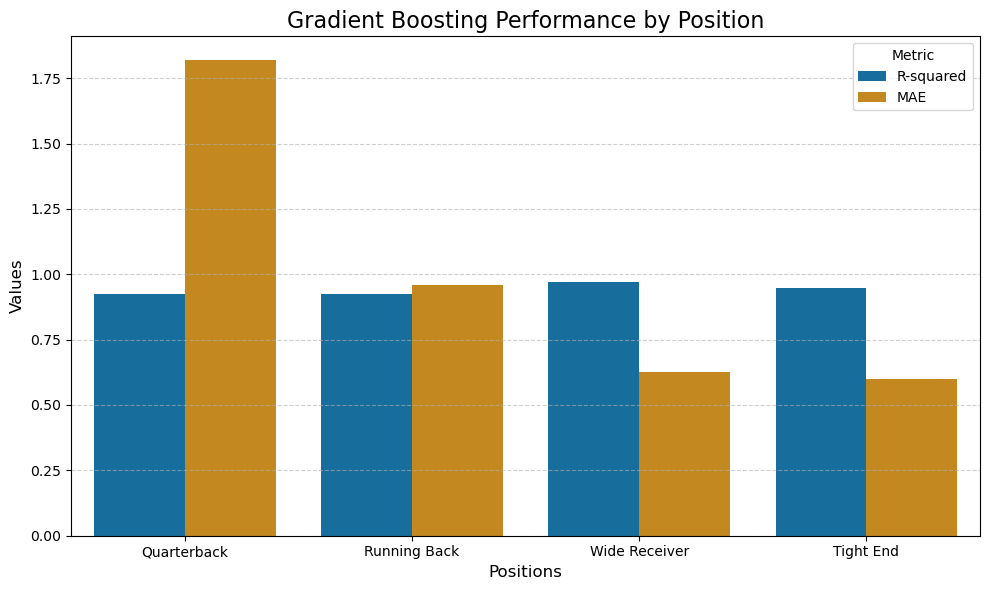

In [93]:
evalData = {
    'Position': ['Quarterback', 'Running Back', 'Wide Receiver', 'Tight End'],
    'R-squared': [0.9242, 0.9253, 0.970084, 0.9465],
    'MAE': [1.819, 0.959, 0.6255, 0.599]
}
#creating dictionary wiht evaluation data

evaldf = pd.DataFrame(evalData)
#turning it into a dataframe

df_melted = evaldf.melt(id_vars='Position', var_name='Metric', value_name='Value')
#melting the dataframe to use seaborn

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Position', y='Value', hue='Metric', palette='colorblind')
plt.title('Gradient Boosting Performance by Position', fontsize=16)
plt.xlabel('Positions', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Metric', fontsize=10)
plt.tight_layout()
plt.show()
#plotting

Quarterbacks:
- R-squared (0.9242): This high value indicates the model captures most of the variance in quarterback fantasy points
- MAE (1.819): This MAE is a much more realistic value, especially in comparison to the other models

Running Backs:
- R-squared (0.9253): Good value at a glance, however we know overfitting is occuring
- MAE (0.959): Extremely low, and unrealistic MAE

Wide Receivers:
- R-squared (0.970084): The highest R-squared among positions
- MAE (0.6255): Extremely low, and unrealistic MAE
    - Along withthe high R-squared, it is clear the model is overfitting, as wide receiver performance can vary significantly depending on game conditions

Tight Ends:
- R-squared (0.9465): This is another strong value at a glance, however we know overfitting is occuring
- MAE (0.599): The lowest MAE among all positions
    - This reflects the overfitting occurring, as tight end performance is often highly variable due to game scripts and reliance on touchdowns


Observations:

The extremely low MAE for wide receivers and tight ends, combined with their high R-squared, indicates overfitting, as these positions tend to have more variability in performance than reflected in the metrics. For quarterbacks, the MAE values align more closely with expectations, as their performance is generally more stable.

**Advanced Modeling Conclusion**
- 

In this notebook, we explored the use of Gradient Boosting models for predicting fantasy points for tight ends. Despite implementing advanced techniques such as Grid Search Cross-Validation and extensive hyperparameter tuning, the models exhibited significant overfitting. The training MAE was extremely low, suggesting the model had effectively memorized the training data, while the test MAE, although higher, was still unrealistically low given the inherent variability in player performance.

This overfitting indicates a mismatch between the complexity of the Gradient Boosting model and the nature of the dataset. NFL player performance is highly variable and influenced by external factors (e.g., game script, injuries, and touchdowns) that are difficult to model this accurately. As a result, the Gradient Boosting model's flexibility and capacity to capture intricate patterns likely lead to it overfitting the training data rather than generalizing well to unseen data.

Given this behavior, it appears that the simpler baseline model (Ridge Regression) may be more suitable for this problem. Ridge regression models, with their inherent regularization and reduced complexity, are less prone to overfitting and often provide more realistic and generalizable predictions in situations where data variability and noise are significant factors.

Moving forward, further exploration of baseline models and simpler approaches should be prioritized, as they are likely to yield better results for this dataset. Additionally, further efforts could be directed toward improving feature engineering, carefully handling potential data leakage, and revisiting the model evaluation strategy to ensure reliable and actionable insights.